# modules

In [53]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from config.config import Config

from scipy.stats import gmean

Config.init()
results_dir = Config.config.dataset.results_save_path
logs_dir = './logs/'

In [120]:
custom_colors = [
    '#9656a2', # purple
    '#f8e16f', # yellow
    '#369acc', # blue
    '#95cf92', # green
    '#de324c', # red
    '#f4895f', # orange
]
rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# data

## training logs

In [143]:
logs_mapping = {
    'full_computational_vector_u500_b500_ent0.5.json': '[Default] Computational Vector',
    'final_hidden_state_u500_b500_ent0.5.json': '[Embedding] Final Hidden State',
    'concat_final_hidden_cell_state_u500_b500_ent0.5.json': '[Embedding] Concat Final Hidden/Cell State',
    'flattened_output_u500_b500_ent0.5.json': '[Embedding] Flattened Output',
    'max_pooling_output_u500_b500_ent0.5.json': '[Embedding] Max Pooling Output',
    'concat_max_pooling_output_final_hidden_state_u500_b500_ent0.5.json': '[Embedding] Concat Max Pooling Output/Final Hidden State',
}

In [144]:
logs = {}
metrics = ['Entropy', 'Episode Length Mean', 'Policy Loss', 'Value Loss', 'Total Loss', 'Reward Min', 'Reward Average', 'Reward Max']

for file in os.listdir(logs_dir):
    with open(logs_dir + file, 'r') as f:
        content = json.load(f)
    key = logs_mapping[file]
    logs[key] = {}
    for metric in metrics:
        logs[key][metric] = []
    for step in content:
        for metric in metrics:
            logs[key][metric].append(step[metric])

## benchmark results

In [284]:
results_mapping = {
    'model_full_computational_vector_u500_b500_ent0.5_426': '[Default] Computational Vector',
    'model_final_hidden_state_u500_b500_ent0.5_416': '[Embedding] Final Hidden State',
    'model_concat_final_hidden_cell_state_u500_b500_ent0.5_486': '[Embedding] Concat Final Hidden/Cell State',
    'model_flattened_output_u500_b500_ent0.5_440': '[Embedding] Flattened Output',
    'model_max_pooling_output_u500_b500_ent0.5_464': '[Embedding] Max Pooling Output',
    'model_concat_max_pooling_output_final_hidden_state_u500_b500_ent0.5_480': '[Embedding] Concat Max Pooling Output/Final Hidden State',
}

In [285]:
results = []

for model_dir in os.listdir(results_dir):
    results_path = f'{results_dir}/{model_dir}/results.json'
    with open(results_path) as f:
        result = json.load(f)
    if 'experiment' not in model_dir:
        model_result = {
            'model': results_mapping[model_dir]
        }
        for k, v in result.items():
            model_result[k] = float(v['speedup'])
        results.append(model_result)

# visualization

## settings

In [162]:
color_indices = {
    '[Default] Computational Vector': 0,
    '[Embedding] Final Hidden State': 1,
    '[Embedding] Concat Final Hidden/Cell State': 2,
    '[Embedding] Flattened Output': 3,
    '[Embedding] Max Pooling Output': 4,
    '[Embedding] Concat Max Pooling Output/Final Hidden State': 5,
}

In [400]:
compressed_method = {
    '[Default] Computational Vector': '[D] Computational Vector',
    '[Embedding] Flattened Output': '[E] Flattened Output',
    '[Embedding] Max Pooling Output': '[E] Max Pool Output',
    '[Embedding] Final Hidden State': '[E] Hidden State',
    '[Embedding] Concat Final Hidden/Cell State': '[E] Concat (Hidden, Cell) States',
    '[Embedding] Concat Max Pooling Output/Final Hidden State': '[E] Concat (Max Pool Output, Hidden)',
}

shortened_method = {
    '[Default] Computational Vector': '[D] C.Vec',
    '[Embedding] Flattened Output': '[E] F.O',
    '[Embedding] Max Pooling Output': '[E] M.P.O',
    '[Embedding] Final Hidden State': '[E] H.S',
    '[Embedding] Concat Final Hidden/Cell State': '[E] C(H.S, C.S)',
    '[Embedding] Concat Max Pooling Output/Final Hidden State': '[E] C(M.P.O, H.S)',
}

shortest_method = {
    '[Default] Computational Vector': 'C.Vec',
    '[Embedding] Flattened Output': 'F.O',
    '[Embedding] Max Pooling Output': 'M.P.O',
    '[Embedding] Final Hidden State': 'H.S',
    '[Embedding] Concat Final Hidden/Cell State': 'C(H.S, C.S)',
    '[Embedding] Concat Max Pooling Output/Final Hidden State': 'C(M.P.O, H.S)',
}

## training

In [ ]:
logs.keys(), logs['[Default] Computational Vector'].keys()

In [175]:
def plot_metric(logs, metric, title=None, figsize=(16, 6), legend_loc='lower right', show_min=False, show_max=False, pre_clip=None, color_indices=None):
    fig, ax = plt.subplots(figsize=figsize)
    
    for key, log in logs.items():
        if pre_clip:
            values = log[metric][pre_clip:]
        else:
            values = log[metric]

        if color_indices:
            color = custom_colors[color_indices[key]]
            line, = ax.plot(values, label=key, color=color)
        else:
            line, = ax.plot(values, label=key)
            color = line.get_color()

        if show_min:
            ax.axhline(y=min(values), color=color, linestyle='-.', label='__nolegend__')
        if show_max:
            ax.axhline(y=max(values), color=color, linestyle='-', label='__nolegend__')

    if title:
        ax.set_title(title)
    elif len(logs)==2:
        ax.set_title(f'{metric} - {compressed_method[list(logs.keys())[0]]} vs {compressed_method[list(logs.keys())[1]]}')
    else:
        ax.set_title(f'{metric}')
    
    if pre_clip:
        ax.set_xlabel('Last Steps')
    else:
        ax.set_xlabel('Update Steps')

    ax.set_ylabel(metric)
    ax.legend(loc=legend_loc)
    
    plt.show()

In [281]:
def plot_max_metric(logs, metric, title=None, figsize=(16, 6), color_indices=None):
    fig, ax = plt.subplots(figsize=figsize)
    
    max_values = []
    for key, log in logs.items():
        max_values.append(max(log[metric]))
        
    logs = dict(sorted(logs.items(), key=lambda item: max(item[1][metric]), reverse=True))
    max_values = sorted(max_values, reverse=True)

    if color_indices:
        colors = [custom_colors[color_indices[key]] for key in logs.keys()]
    else:
        colors = None

    width = 0.5
    
    for idx, (key, max_value) in enumerate(zip(logs.keys(), max_values)):
        ax.bar(idx, max_value, width=width, color=colors[idx] if colors else None, edgecolor='black', label=key)
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Maximum {metric}')
    
    ax.set_ylabel(metric)
    ax.set_xticks(ticks=range(len(logs.keys())))
    ax.set_xticklabels(labels=[shortened_method[label] for label in logs.keys()], rotation=90)
    
    ax.legend([compressed_method[m] for m in logs.keys()] ,loc='upper right', bbox_to_anchor=(2, 1))
    
    plt.tight_layout()
    plt.show()


### pairwise comapraison

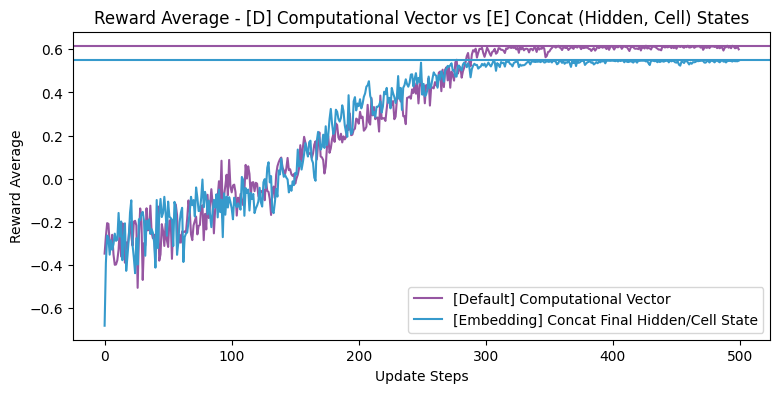

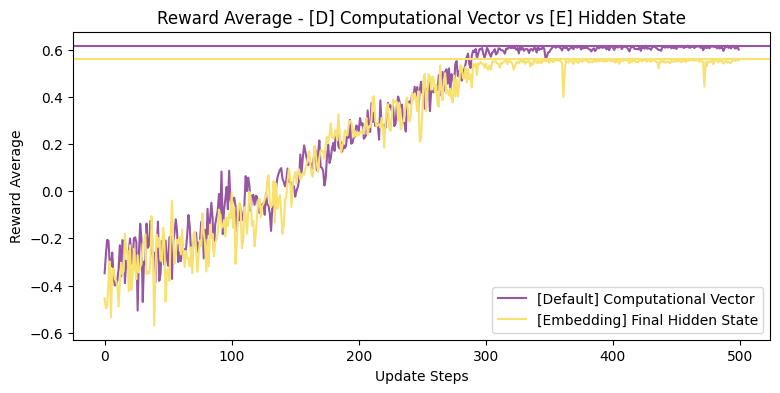

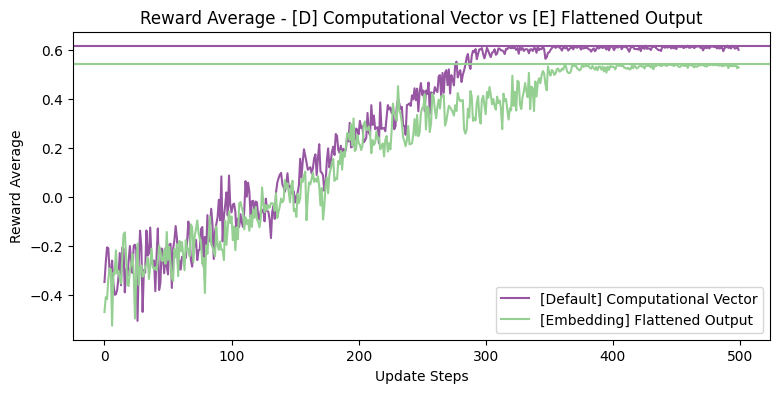

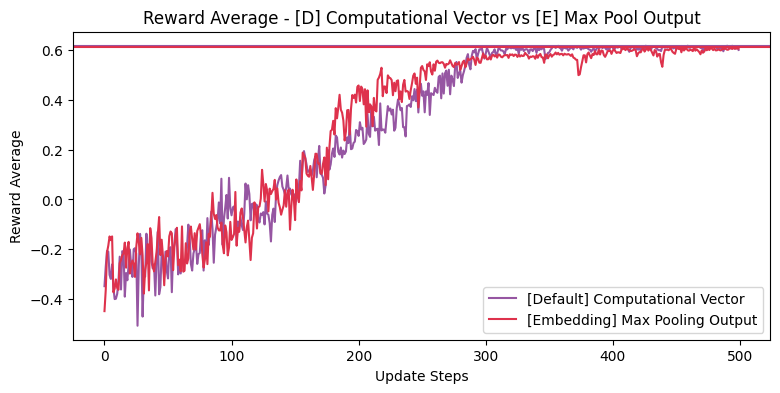

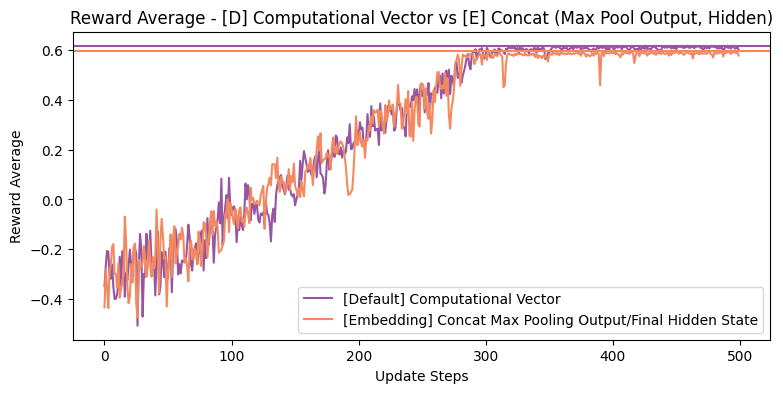

In [176]:
no_embedding = '[Default] Computational Vector'
for embedding in logs.keys():
    if embedding != no_embedding:
        log = {}
        log[no_embedding] = logs[no_embedding]
        log[embedding] = logs[embedding]
        plot_metric(log, 'Reward Average', figsize=(9, 4), legend_loc='lower right', show_max=True, pre_clip=None, color_indices=color_indices)

### overall comparaison

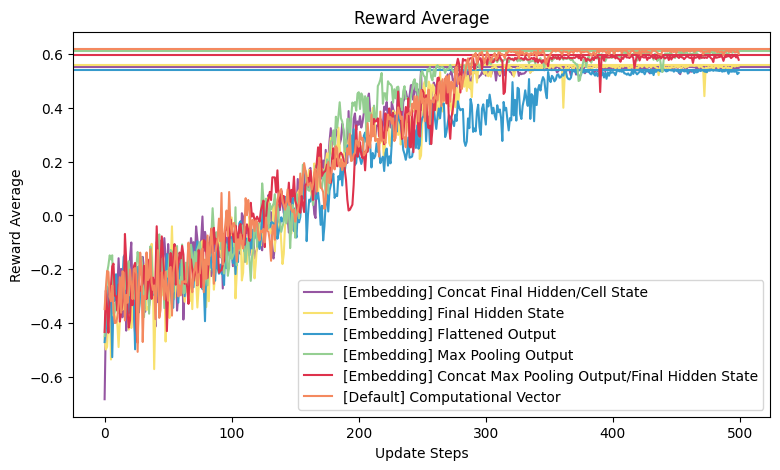

In [199]:
plot_metric(logs, 'Reward Average', figsize=(9, 5), legend_loc='lower right', show_max=True)

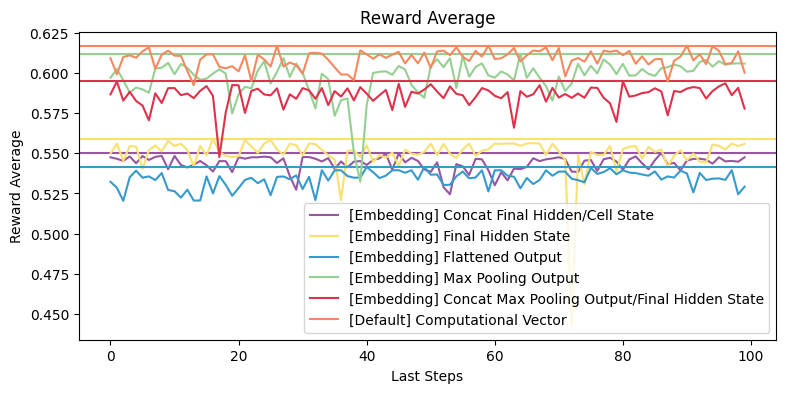

In [200]:
plot_metric(logs, 'Reward Average', figsize=(9, 4), legend_loc='lower right', show_max=True, pre_clip=400)

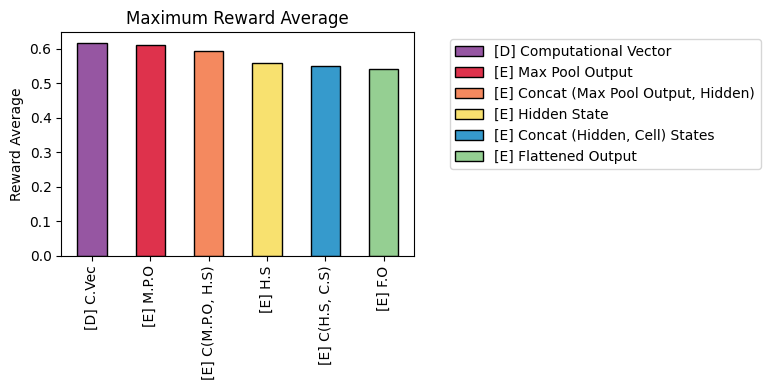

In [282]:
plot_max_metric(logs, 'Reward Average', figsize=(19, 4), color_indices=color_indices)

## benchmark

In [339]:
baseline_model = '[Default] Computational Vector'

In [341]:
models = [result['model'] for result in results]
functions = [key for key in results[0].keys() if key != 'model']
num_functions = len(functions)
data = {function: [result[function] for result in results] for function in functions}

In [405]:
def plot_functions_acceleration(data, models, functions, color_indices, baseline_model='[Default] Computational Vector', sort_bars=True, figsize=(14, 10), legend_loc='upper left'):
    n_functions = len(functions)
    n_cols = 2
    n_rows = (n_functions + n_cols - 1) // n_cols
    width = 0.5
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    ax = ax.flatten()

    colors = [custom_colors[color_indices[model]] for model in models if model != baseline_model]

    for idx, function in enumerate(functions):
        baseline_value = data[function][models.index(baseline_model)]
        
        ax[idx].axhline(y=baseline_value, color=custom_colors[color_indices[baseline_model]], linestyle='solid', label='Default')
        # include y=1 line for reference
        ax[idx].axhline(y=1, color='black', linestyle='dashed', label='No Acceleration')
        
        filtered_models = [model for model in models if model != baseline_model]
        filtered_data = [data[function][models.index(model)] for model in filtered_models]
        filtered_colors = [custom_colors[color_indices[model]] for model in filtered_models]

        if sort_bars:
            sorted_indices = np.argsort(filtered_data)[::-1]
        else:
            sorted_indices = np.arange(len(filtered_data))
        
        sorted_models = np.array(filtered_models)[sorted_indices]
        sorted_data = np.array(filtered_data)[sorted_indices]
        sorted_colors = np.array(filtered_colors)[sorted_indices]

        ax[idx].bar(sorted_models, sorted_data, color=sorted_colors, edgecolor='black', width=width)
        
        ax[idx].set_title(function)
        ax[idx].set_ylabel('Speedup')
        ax[idx].set_ylim(bottom=0)

        ax[idx].set_xticks(range(len(sorted_models)))
        ax[idx].set_xticklabels([shortest_method[m] for m in sorted_models], rotation=0)

    # offset ourside plot
    ax[1].legend(loc=legend_loc, bbox_to_anchor=(1, 1))

    # add title
    plt.suptitle('Speedup of Embedding Methods Compared to Default Computational Vector', fontsize=14)
    
    plt.tight_layout()
    plt.show()


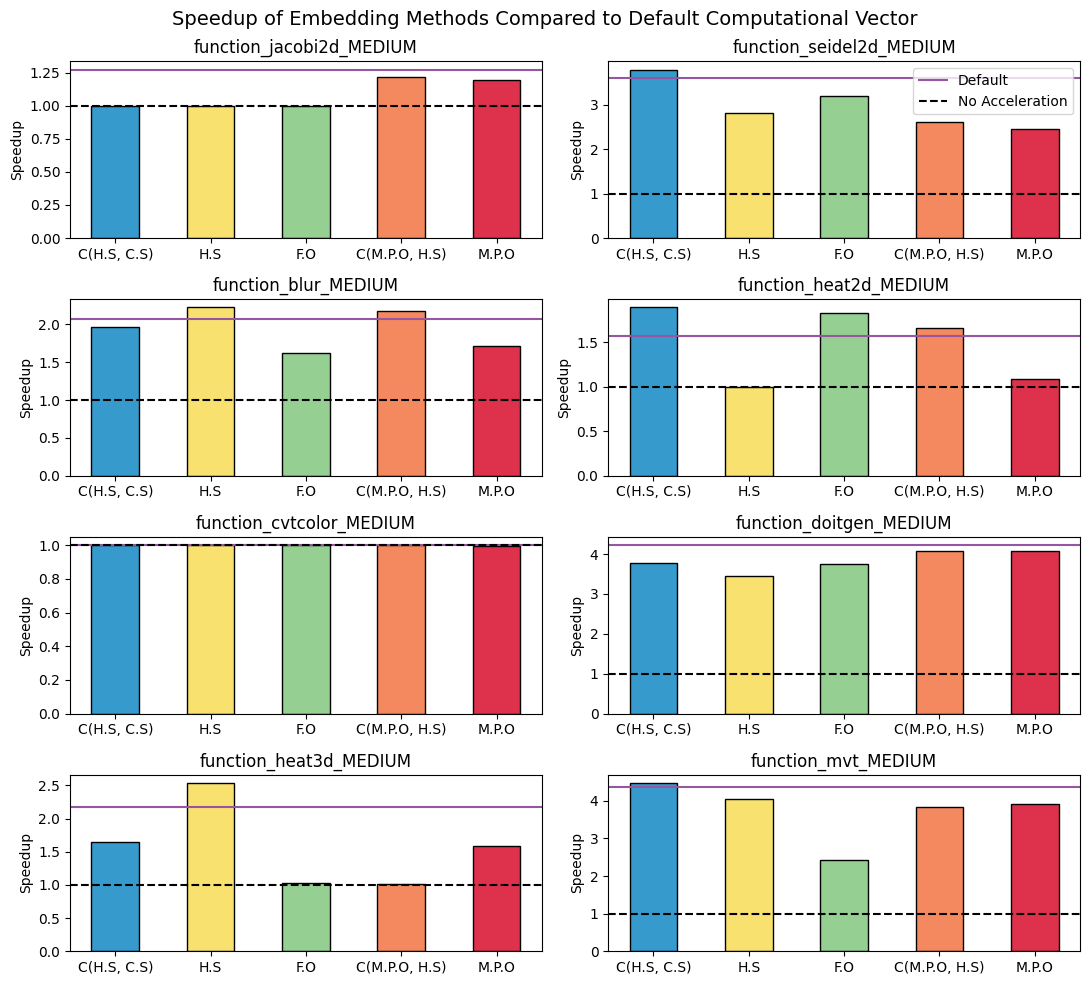

In [406]:
plot_functions_acceleration(data, models, functions, figsize=(11, 10), color_indices=color_indices, sort_bars=False, legend_loc='upper right')

In [421]:
def plot_geometric_mean_speedup(data, models, functions, color_indices, baseline_model='[Default] Computational Vector', figsize=(10, 6)):
    width = 0.5
    geom_means = [gmean([data[function][models.index(model)] for function in functions]) for model in models]
    
    sorted_indices = np.argsort(geom_means)[::-1]
    sorted_models = np.array(models)[sorted_indices]
    sorted_geom_means = np.array(geom_means)[sorted_indices]
    sorted_colors = np.array([custom_colors[color_indices[model]] for model in models])[sorted_indices]

    fig, ax = plt.subplots(figsize=figsize)
    for idx, (model, geom_mean) in enumerate(zip(sorted_models, sorted_geom_means)):
        ax.bar(idx, geom_mean, color=sorted_colors[idx], edgecolor='black', width=width, label=model)
    
    ax.set_title('Geometric Mean of Speedups Across Functions')
    ax.set_ylabel('Geometric Mean Speedup')
    ax.set_xticks(ticks=range(len(sorted_models)))
    ax.set_xticklabels([shortened_method[m] for m in sorted_models], rotation=90)

    ax.legend([compressed_method[m] for m in sorted_models] + ['No Acceleration', 'Default'], loc='upper right', bbox_to_anchor=(2, 1))
    
    plt.tight_layout()
    plt.show()


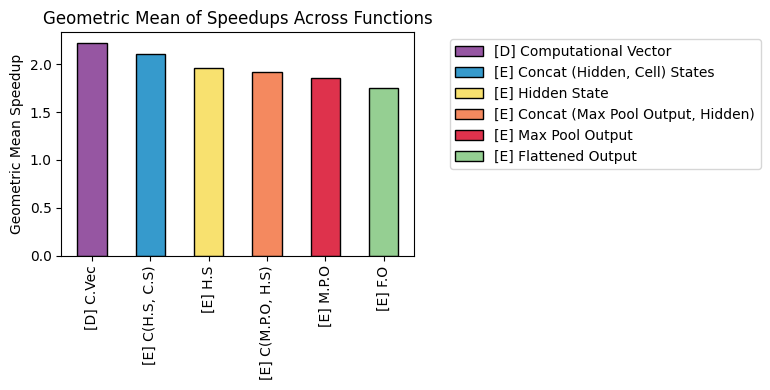

In [422]:
plot_geometric_mean_speedup(data, models, functions, color_indices, figsize=(19, 4))

In [424]:
computational_vector_sizes = {
    '[Embedding] Concat Final Hidden/Cell State': 175,
    '[Embedding] Final Hidden State': 95,
    '[Embedding] Flattened Output': 655,
    '[Embedding] Concat Max Pooling Output/Final Hidden State': 111,
    '[Embedding] Max Pooling Output': 31,
    '[Default] Computational Vector': 718
}

In [443]:
def plot_computational_vector_sizes(vector_sizes, color_indices, baseline_model='[Default] Computational Vector', figsize=(10, 6)):
    width = 0.5
    sorted_models = sorted(vector_sizes.keys(), key=lambda x: vector_sizes[x], reverse=True)
    sorted_sizes = [vector_sizes[model] for model in sorted_models]
    sorted_colors = [custom_colors[color_indices[model]] for model in sorted_models]

    fig, ax = plt.subplots(figsize=figsize)
    for idx, (model, size) in enumerate(zip(sorted_models, sorted_sizes)):
        ax.bar(idx, size, color=sorted_colors[idx], edgecolor='black', width=width, label=model)

    # baseline_size = vector_sizes[baseline_model]
    # ax.axhline(y=baseline_size, color=custom_colors[color_indices[baseline_model]], linestyle='solid', label='Default')

    ax.set_title('Computational Vector Sizes')
    ax.set_ylabel('Vector Size')
    ax.set_xticks(ticks=range(len(sorted_models)))
    ax.set_xticklabels([shortened_method[m] for m in sorted_models], rotation=90)

    ax.legend([compressed_method[m] for m in sorted_models] + ['Default'], loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


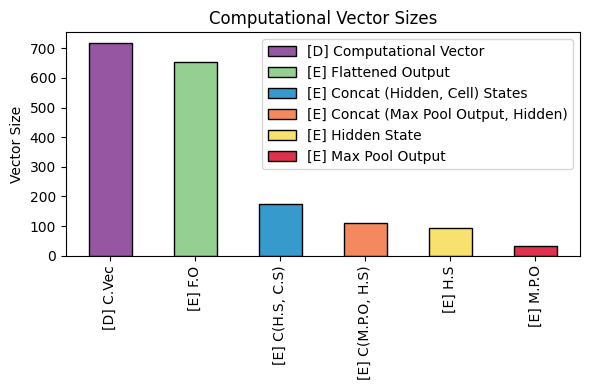

In [444]:
plot_computational_vector_sizes(computational_vector_sizes, color_indices, figsize=(6, 4))